# Trajectory Inference with StaVIA

VIA is a single-cell Trajectory Inference method that offers topology construction, pseudotimes, automated terminal state prediction and automated plotting of temporal gene dynamics along lineages. Here, we have improved the original author's colouring logic and user habits so that users can use the anndata object directly for analysis。 

We have completed this tutorial using the analysis provided by the original VIA authors.

Paper: [Generalized and scalable trajectory inference in single-cell omics data with VIA](https://www.nature.com/articles/s41467-021-25773-3)

Code: https://github.com/ShobiStassen/VIA

Colab_Reproducibility：https://colab.research.google.com/drive/1A2X23z_RLJaYLbXaiCbZa-fjNbuGACrD?usp=sharing

In [2]:
import scanpy as sc
import omicverse as ov
from omicverse.external import VIA

import matplotlib.pyplot as plt
ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 04日 星期一 20:58:43 CST


## Preprocess data

As an example, we apply differential kinetic analysis to dentate gyrus neurogenesis, which comprises multiple heterogeneous subpopulations.

In [3]:
import scvelo as scv
adata=scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [4]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

Begin robust gene identification
After filtration, 13264/13913 genes are kept.     Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell
The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 0.5831606388092041 seconds.
End of size normalization: shiftlog and HVGs selection pearson
computing PCA
    with n_comps=50
    finished (0:00:00)


In [5]:
ov.pp.neighbors(adata,use_rep='scaled|original|X_pca',n_neighbors=15,n_pcs=30)
ov.pp.umap(adata,min_dist=1)

🖥️ Using Scanpy CPU to calculate neighbors...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
🔍 [2025-08-04 20:58:49] Running UMAP in 'cpu' mode...
🖥️ Using Scanpy CPU UMAP...
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)
✅ UMAP completed successfully.


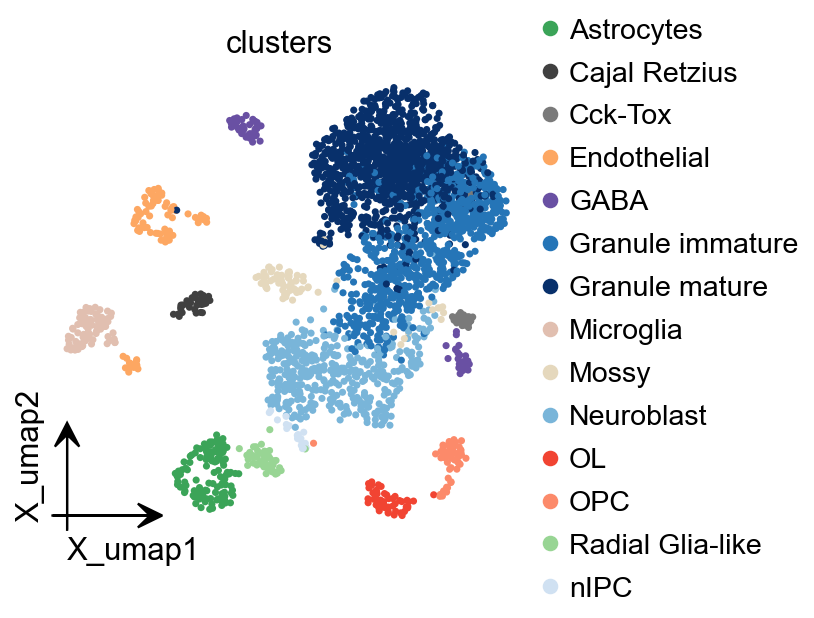

In [6]:
ov.pl.embedding(adata,basis='X_umap',
                   color=['clusters'],
                   frameon='small',cmap='Reds')

## Model construct and run

We need to specify the cell feature vector `use_rep` used for VIA inference, which can be X_pca, X_scVI or X_glue, depending on the purpose of your analysis, here we use X_pca directly. We also need to specify how many components to be used, the components should not larger than the length of vector.

Besides, we need to specify the `clusters` to be colored and calculate for VIA. If the `root_user` is None, it will be calculated the root cell automatically.

We need to set `basis` argument stored in `adata.obsm`. An example setting `tsne` because it stored in `obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_pca'`

We also need to set `clusters` argument stored in `adata.obs`. It means the celltype key.

Other explaination of argument and attributes could be found at https://pyvia.readthedocs.io/en/latest/notebooks/ViaJupyter_scRNA_Hematopoiesis.html

**StaVia for time-series**
- [Via 2.0 Cartography on Mouse Gastrulation](https://pyvia.readthedocs.io/en/latest/notebooks/Via2.0%20Cartographic%20Mouse%20Gastrualation.html)
- [Via 2.0 Cartography on Zebrahub (Trajectory Inference)](https://pyvia.readthedocs.io/en/latest/notebooks/Zebrahub%20TI%20tutorial.html)
- [Via 2.0 Cartography on Zebrahub (Visualization)](https://pyvia.readthedocs.io/en/latest/notebooks/Zebrahub_tutorial_visualization.html)

**StaVia for spatial-temporal**
- [Stavia Spatially aware cartography on MERFISH](https://pyvia.readthedocs.io/en/latest/notebooks/StaVia%20MERFISH%202.html)
- [StaVia TI for Spatio-temporal Analysis of single cell data](https://pyvia.readthedocs.io/en/latest/notebooks/Zesta_jp_tutorial.html)

In [7]:
ncomps=30
knn=15
v0_random_seed=4
root_user = ['nIPC'] #the index of a cell belonging to the nIPC cell type
memory = 10
dataset = ''
use_rep = 'scaled|original|X_pca'
clusters = 'clusters'
basis='X_umap'

'''
#NOTE1, if you decide to choose a cell type as a root, then you need to set the dataset as 'group'
#root_user=['HSC1']
#dataset = 'group'# 'humanCD34'
#NOTE2, if rna-velocity is available, considering using it to compute the root automatically- see RNA velocity tutorial
'''

v0 = VIA.core.VIA(data=adata.obsm[use_rep][:, 0:ncomps], 
             true_label=adata.obs[clusters], 
             edgepruning_clustering_resolution=0.15, cluster_graph_pruning=0.15,
             knn=knn,  root_user=root_user, resolution_parameter=1.5,
             dataset=dataset, random_seed=v0_random_seed, memory=memory)#, do_compute_embedding=True, embedding_type='via-atlas')

v0.run_VIA()

2025-08-04 20:58:54.660619	Running VIA over input data of 2930 (samples) x 30 (features)
2025-08-04 20:58:54.660768	Knngraph has 15 neighbors
2025-08-04 20:58:55.991152	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 43.8 % of edges. 
2025-08-04 20:58:56.005197	Number of connected components used for clustergraph  is 1
2025-08-04 20:58:56.068989	Commencing community detection
2025-08-04 20:58:56.273448	Finished community detection. Found 537 clusters.
2025-08-04 20:58:56.275163	Merging 496 very small clusters (<10)
2025-08-04 20:58:56.282648	Finished detecting communities. Found 41 communities
2025-08-04 20:58:56.282887	Making cluster graph. Global cluster graph pruning level: 0.15
2025-08-04 20:58:56.289289	Graph has 1 connected components before pruning
2025-08-04 20:58:56.292317	Graph has 14 connected components after pruning
2025-08-04 20:58:56.304845	Graph has 1 connected components after reconnecting
2025-08-04 20:58:56.305568	0.0% links trimmed

  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2025-08-04 20:59:22.264990	Identifying terminal clusters corresponding to unique lineages...
2025-08-04 20:59:22.265041	Closeness:[8, 10, 11, 15, 16, 19, 20, 21, 25, 26, 28, 31, 36, 38, 40]
2025-08-04 20:59:22.265066	Betweenness:[0, 2, 4, 5, 7, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 22, 25, 28, 30, 31, 32, 34, 36, 38, 39]
2025-08-04 20:59:22.265084	Out Degree:[4, 5, 7, 8, 10, 11, 15, 16, 17, 20, 21, 24, 25, 26, 28, 30, 31, 34, 36, 38, 39, 40]
2025-08-04 20:59:22.265534	Terminal clusters corresponding to unique lineages in this component are [34, 4, 5, 36, 7, 8, 38, 11, 39, 16, 19, 25, 26, 30, 31] 
2025-08-04 20:59:22.265581	Calculating lineage probability at memory 10


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-08-04 20:59:26.482688	Cluster or terminal cell fate 34 is reached 213.0 times
2025-08-04 20:59:26.547344	Cluster or terminal cell fate 4 is reached 290.0 times
2025-08-04 20:59:26.612773	Cluster or terminal cell fate 5 is reached 130.0 times
2025-08-04 20:59:26.678063	Cluster or terminal cell fate 36 is reached 2.0 times
2025-08-04 20:59:26.725075	Cluster or terminal cell fate 7 is reached 845.0 times
2025-08-04 20:59:26.795479	Cluster or terminal cell fate 8 is reached 2.0 times
2025-08-04 20:59:26.862901	Cluster or terminal cell fate 38 is reached 1.0 times
2025-08-04 20:59:26.934373	Cluster or terminal cell fate 11 is reached 44.0 times
2025-08-04 20:59:27.002123	Cluster or terminal cell fate 39 is reached 301.0 times
2025-08-04 20:59:27.072494	Cluster or terminal cell fate 16 is reached 15.0 times
2025-08-04 20:59:27.144823	Cluster or terminal cell fate 19 is reached 1.0 times
2025-08-04 20:59:27.221405	Cluster or terminal cell fate 25 is reached 6.0 times
2025-08-04 20:59:27.

## Visualize and analysis

Before the subsequent analysis, we need to specify the colour of each cluster. Here we use sc.pl.embedding to automatically colour each cluster, if you need to specify your own colours, specify the palette parameter

tune edges False


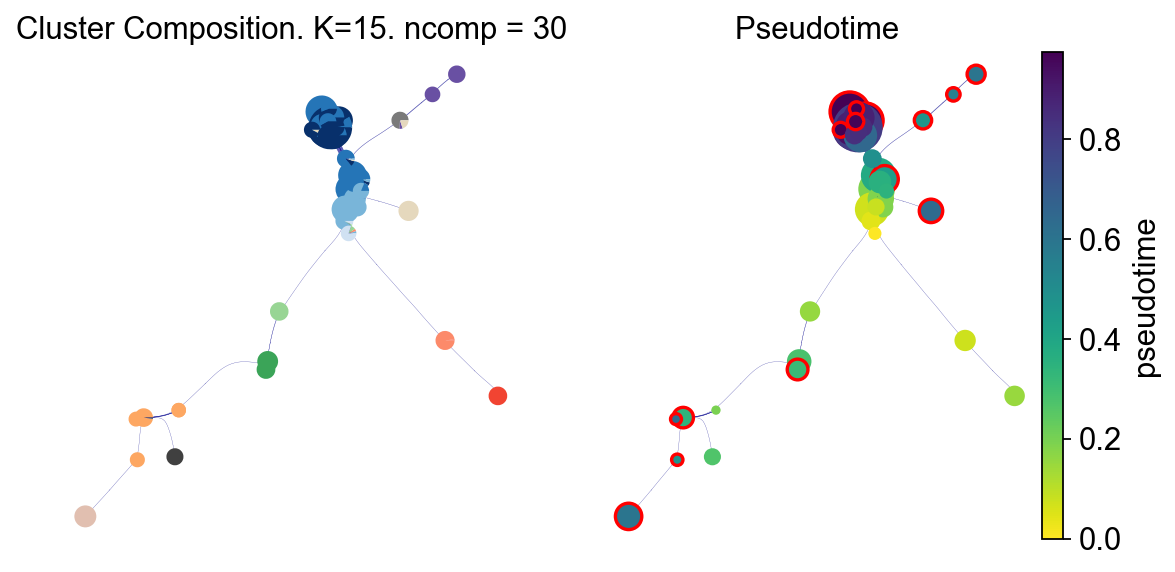

In [8]:
fig, ax, ax1 = VIA.core.plot_piechart_viagraph_ov(adata,clusters='clusters',dpi=80,
                                             via_object=v0, ax_text=False,show_legend=False)
fig.set_size_inches(8,4)

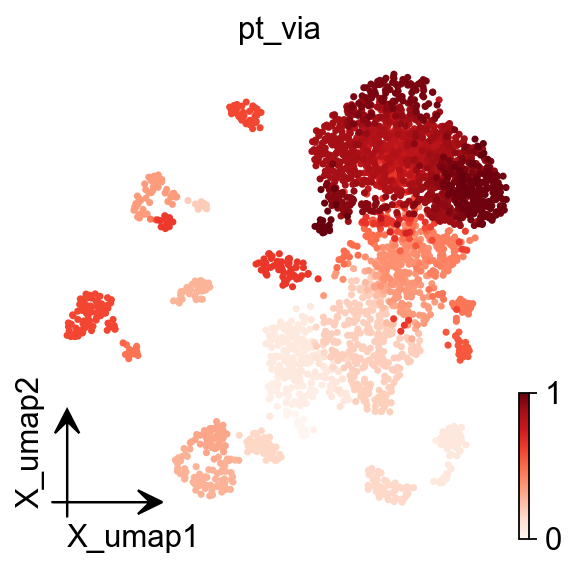

In [9]:
adata.obs['pt_via']=v0.single_cell_pt_markov
ov.pl.embedding(adata,basis='X_umap',
                   color=['pt_via'],
                   frameon='small',cmap='Reds')

## Trajectory projection

Visualize the overall VIA trajectory projected onto a 2D embedding (UMAP, Phate, TSNE etc) in different ways.

1. Draw the high-level clustergraph abstraction onto the embedding;
2. Draw high-edge resolution directed graph
3. Draw a vector field/stream plot of the more fine-grained directionality of cells along the trajectory projected onto an embedding.

Key Parameters:
- scatter_size
- scatter_alpha
- linewidth
- draw_all_curves (if too crowded, set to False)

In [10]:
clusters='clusters'
color_true_list=adata.uns['{}_colors'.format(clusters)]

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                    

2025-08-04 20:59:58.381160	Super cluster 4 is a super terminal with sub_terminal cluster 34
2025-08-04 20:59:58.381456	Super cluster 5 is a super terminal with sub_terminal cluster 4
2025-08-04 20:59:58.381548	Super cluster 7 is a super terminal with sub_terminal cluster 5
2025-08-04 20:59:58.381629	Super cluster 8 is a super terminal with sub_terminal cluster 36
2025-08-04 20:59:58.381712	Super cluster 11 is a super terminal with sub_terminal cluster 7
2025-08-04 20:59:58.381798	Super cluster 16 is a super terminal with sub_terminal cluster 8
2025-08-04 20:59:58.381894	Super cluster 19 is a super terminal with sub_terminal cluster 38
2025-08-04 20:59:58.381998	Super cluster 25 is a super terminal with sub_terminal cluster 11
2025-08-04 20:59:58.382081	Super cluster 26 is a super terminal with sub_terminal cluster 39
2025-08-04 20:59:58.382166	Super cluster 30 is a super terminal with sub_terminal cluster 16
2025-08-04 20:59:58.382248	Super cluster 31 is a super terminal with sub_termi

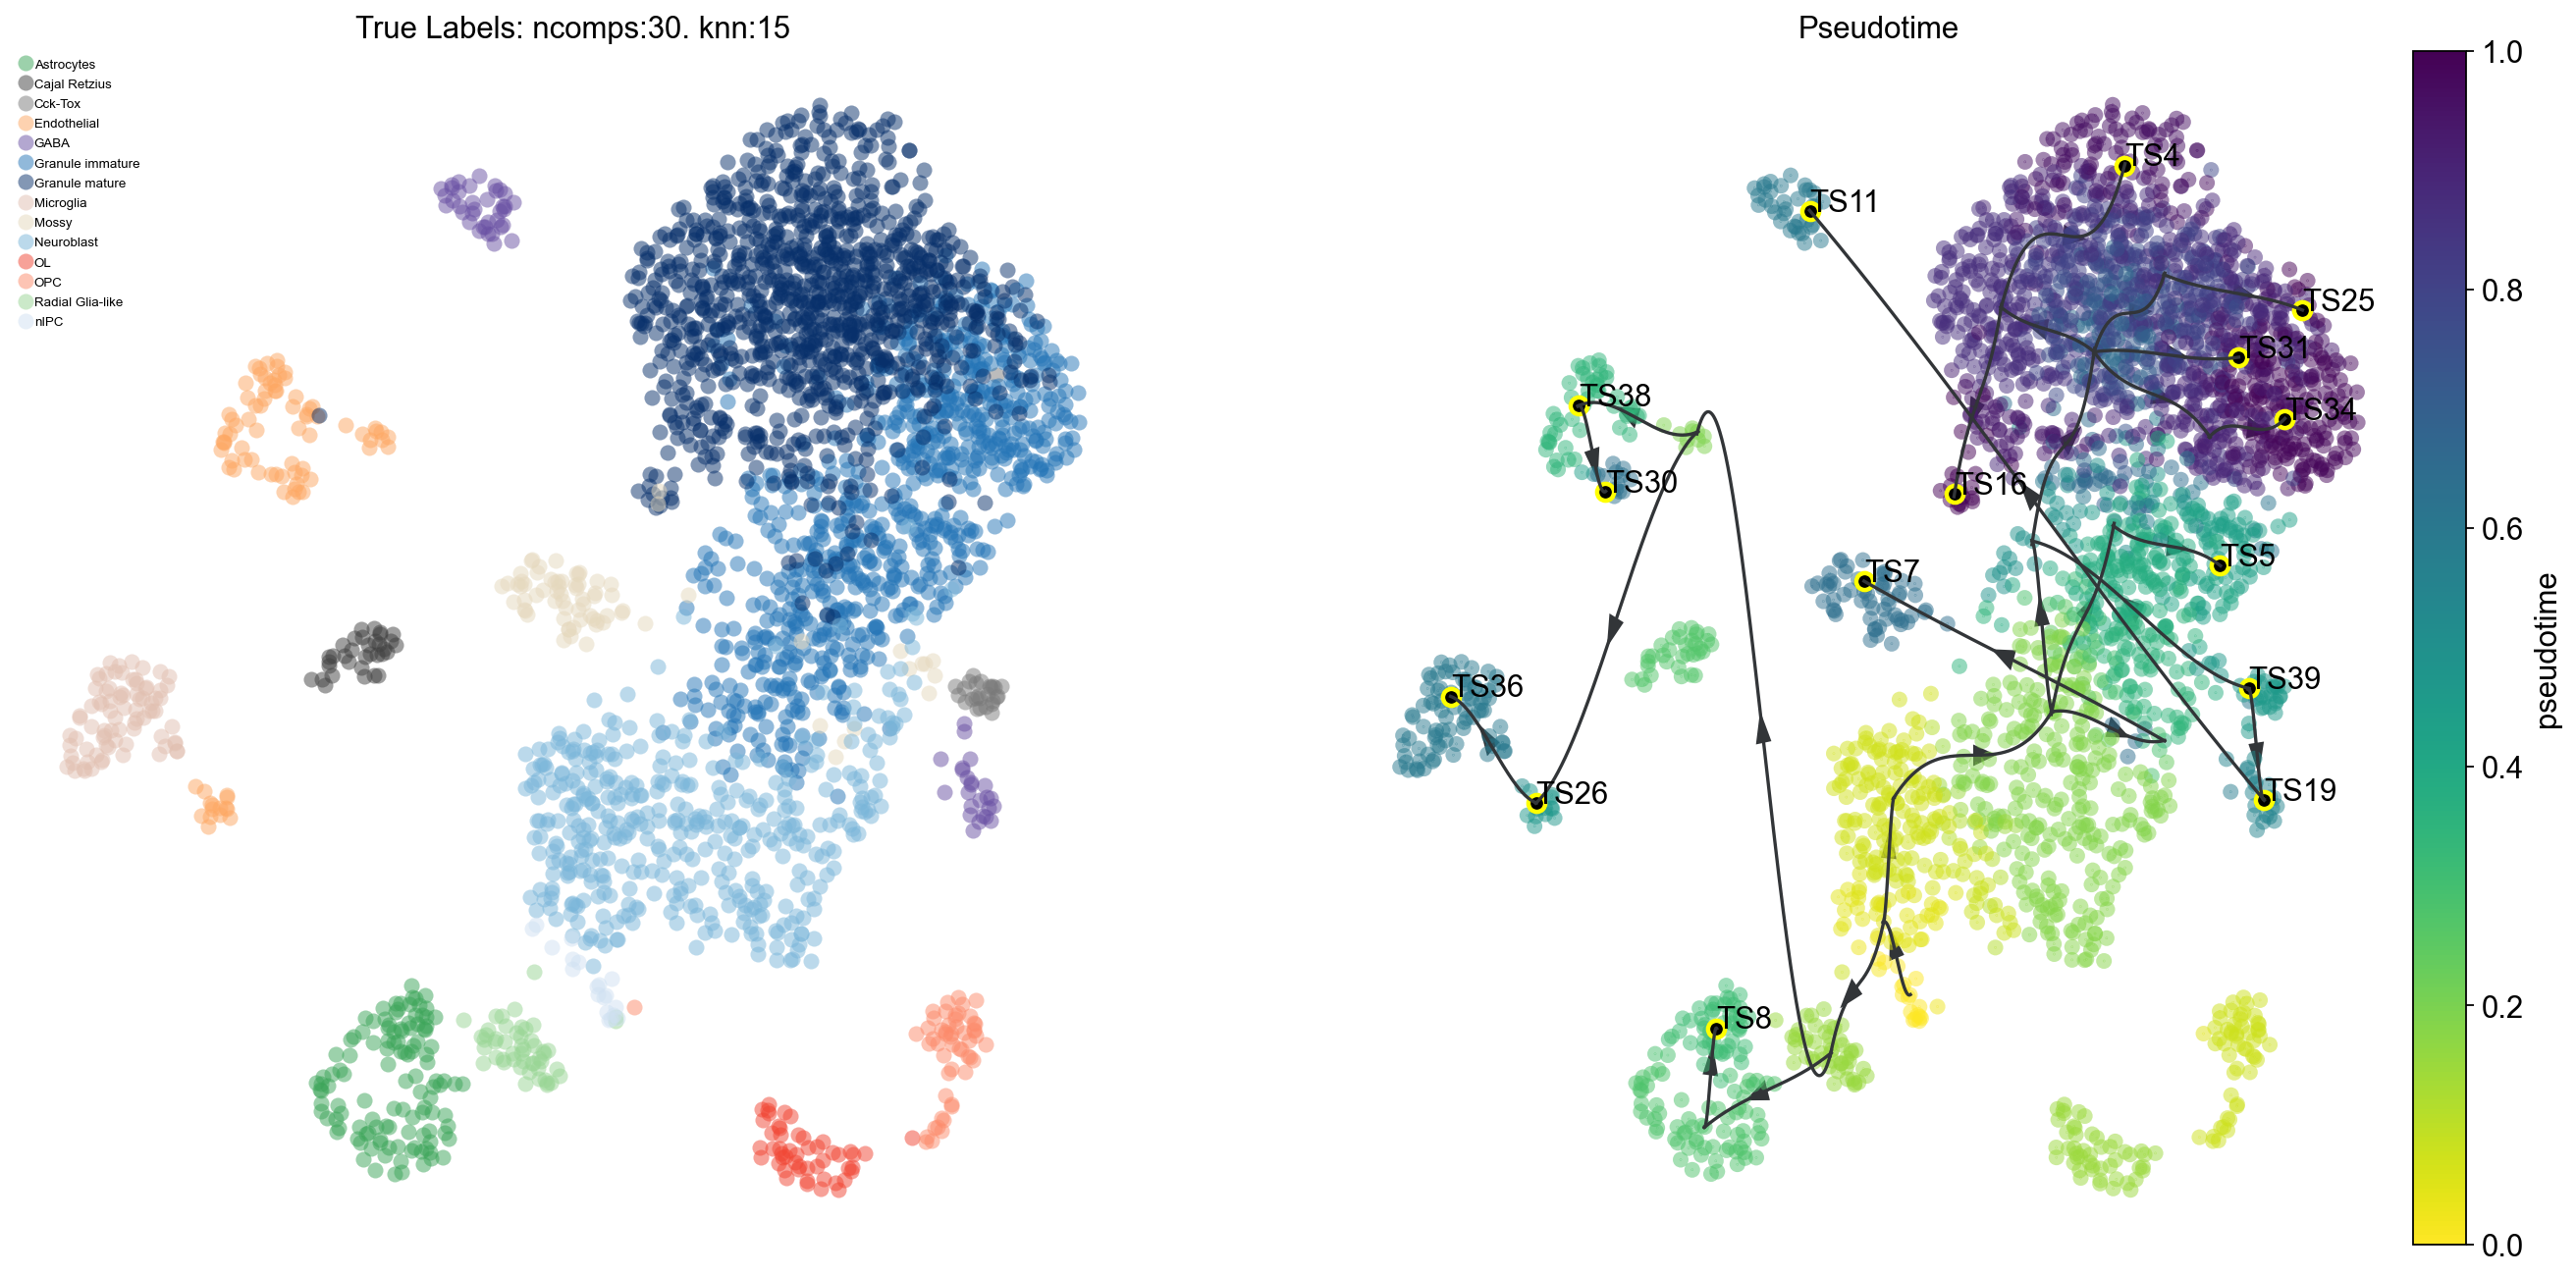

In [ ]:
fig, ax, ax1 = VIA.core.plot_trajectory_curves_ov(adata,clusters='clusters',dpi=80,
                                                  via_object=v0,embedding=adata.obsm['X_umap'],
                                               draw_all_curves=False)

2025-08-04 21:00:00.627109	Computing Edges
2025-08-04 21:00:00.627233	Start finding milestones
2025-08-04 21:00:01.502086	End milestones with 150
2025-08-04 21:00:01.508145	Recompute weights
2025-08-04 21:00:01.521056	pruning milestone graph based on recomputed weights
2025-08-04 21:00:01.522092	Graph has 1 connected components before pruning
2025-08-04 21:00:01.522904	Graph has 7 connected components after pruning
2025-08-04 21:00:01.530446	Graph has 1 connected components after reconnecting
2025-08-04 21:00:01.531446	regenerate igraph on pruned edges
2025-08-04 21:00:01.540112	Setting numeric label as time_series_labels or other sequential metadata for coloring edges
2025-08-04 21:00:01.551598	Making smooth edges
inside add sc embedding second if


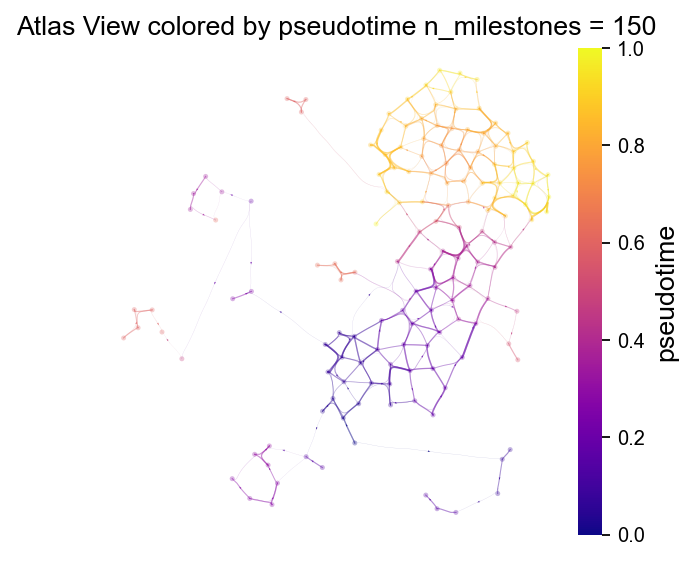

In [12]:
v0.embedding = adata.obsm['X_umap']
fig, ax = VIA.core.plot_atlas_view(via_object=v0, 
                                   n_milestones=150, 
                                   sc_labels=adata.obs['clusters'], 
                                   fontsize_title=12,
                                   fontsize_labels=12,dpi=80,
                                   extra_title_text='Atlas View colored by pseudotime')
fig.set_size_inches(4,4)

In [13]:
# edge plots can be made with different edge resolutions. Run hammerbundle_milestone_dict() to recompute the edges for plotting. Then provide the new hammerbundle as a parameter to plot_edge_bundle()
# it is better to compute the edges and save them to the via_object. this gives more control to the merging of edges
decay = 0.6 #increasing decay increasing merging of edges
i_bw = 0.02 #increasing bw increases merging of edges
global_visual_pruning = 0.5 #higher number retains more edges
n_milestones = 200

v0.hammerbundle_milestone_dict= VIA.core.make_edgebundle_milestone(via_object=v0, 
                                                              n_milestones=n_milestones, 
                                                              decay=decay, initial_bandwidth=i_bw,
                                                              global_visual_pruning=global_visual_pruning)


2025-08-04 21:00:03.472215	Start finding milestones
2025-08-04 21:00:04.560103	End milestones with 200
2025-08-04 21:00:04.565930	Recompute weights
2025-08-04 21:00:04.581495	pruning milestone graph based on recomputed weights
2025-08-04 21:00:04.582593	Graph has 1 connected components before pruning
2025-08-04 21:00:04.583409	Graph has 6 connected components after pruning
2025-08-04 21:00:04.589667	Graph has 1 connected components after reconnecting
2025-08-04 21:00:04.590828	regenerate igraph on pruned edges
2025-08-04 21:00:04.599686	Setting numeric label as single cell pseudotime for coloring edges
2025-08-04 21:00:04.612024	Making smooth edges


inside add sc embedding second if


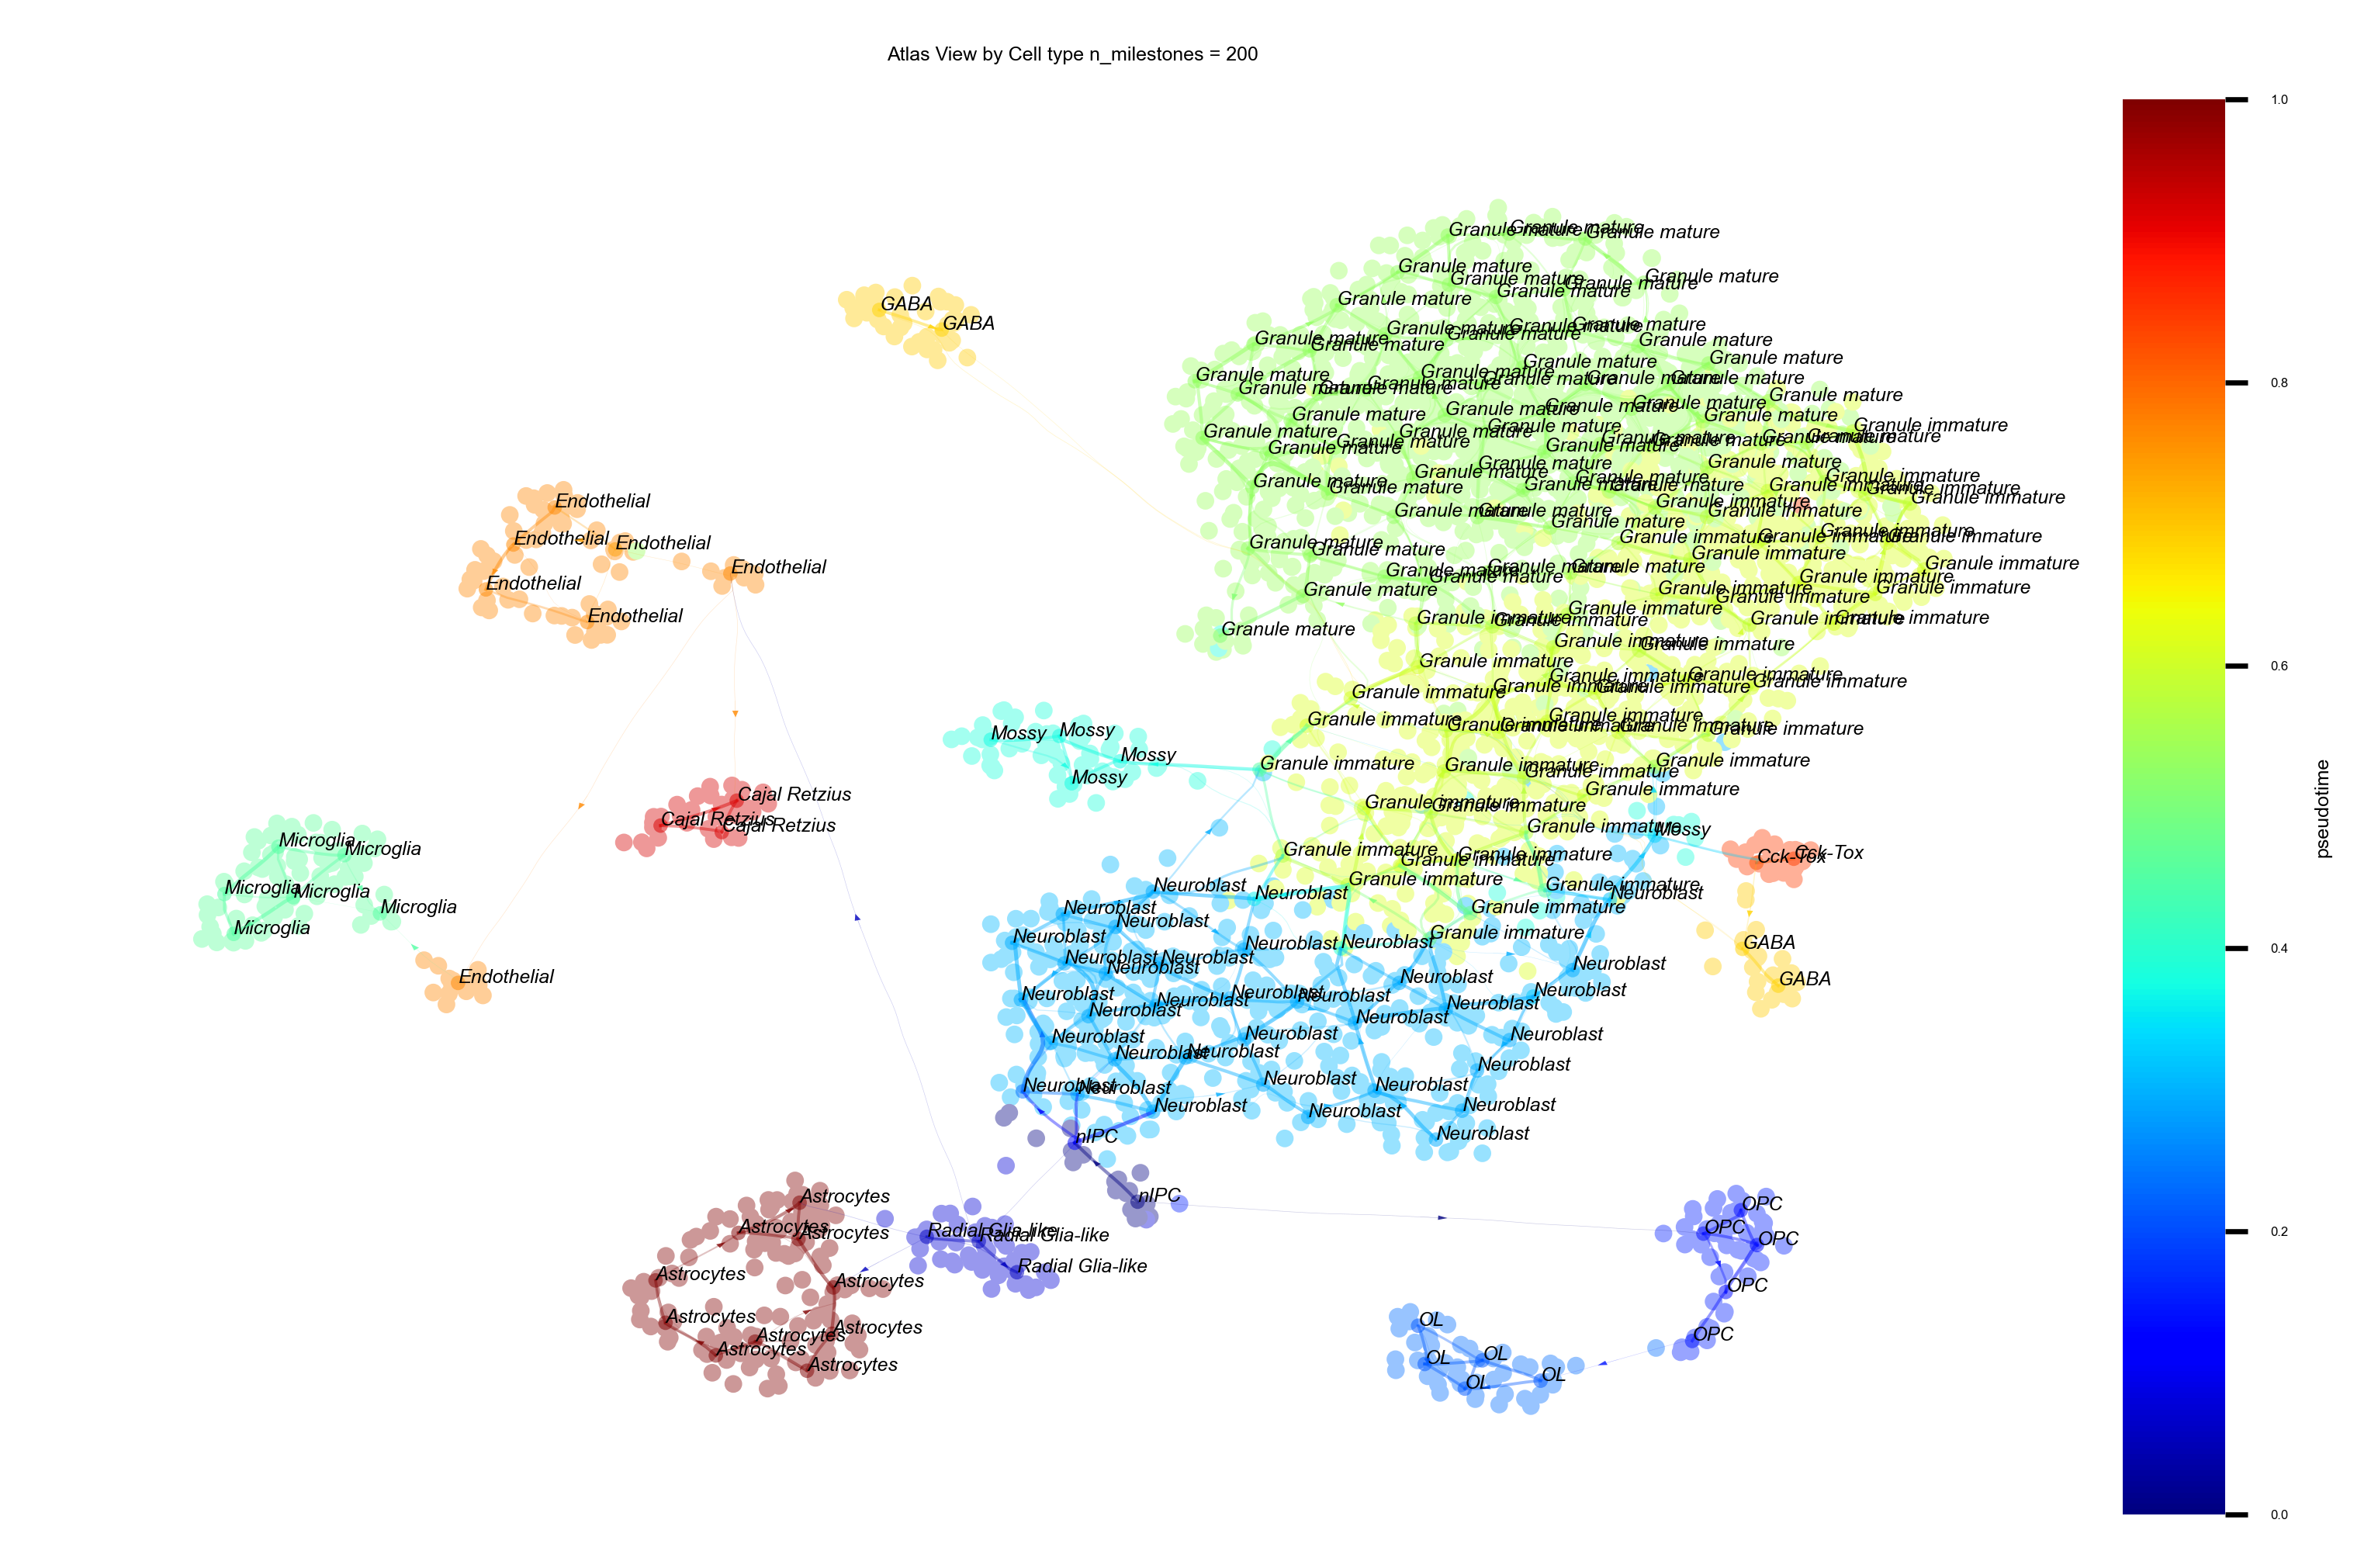

In [14]:
fig, ax = VIA.core.plot_atlas_view(via_object=v0,  
                              add_sc_embedding=True, 
                              sc_labels_expression=adata.obs['clusters'], 
                              cmap='jet', sc_labels=adata.obs['clusters'], 
                              text_labels=True, 
                              extra_title_text='Atlas View by Cell type', 
                              fontsize_labels=3,fontsize_title=3,dpi=300
                             )
fig.set_size_inches(6,4)

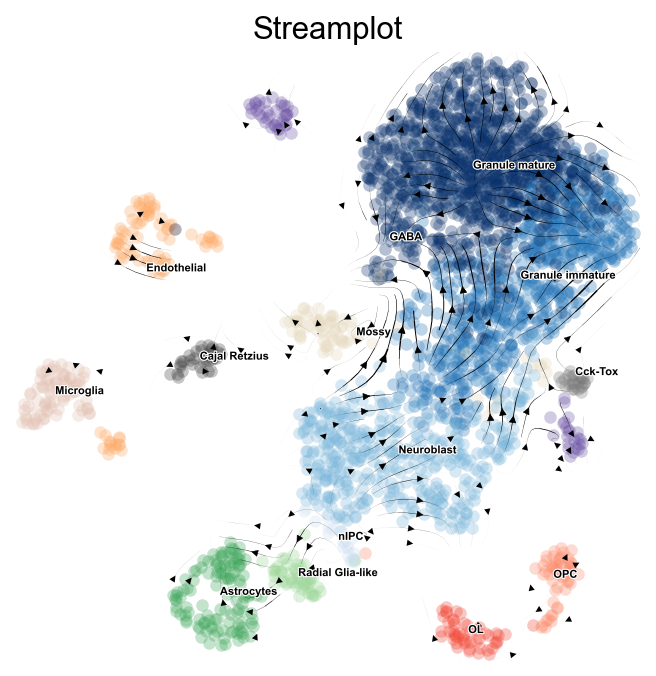

In [15]:
# via_streamplot() requires you to either provide an ndarray as embedding as an input parameter OR for via to have an embedding attribute
fig, ax = VIA.core.via_streamplot_ov(adata,'clusters',
                                     v0, embedding=adata.obsm['X_umap'], dpi=80,
                             density_grid=0.8, scatter_size=30, 
                             scatter_alpha=0.3, linewidth=0.5)
fig.set_size_inches(5,5)

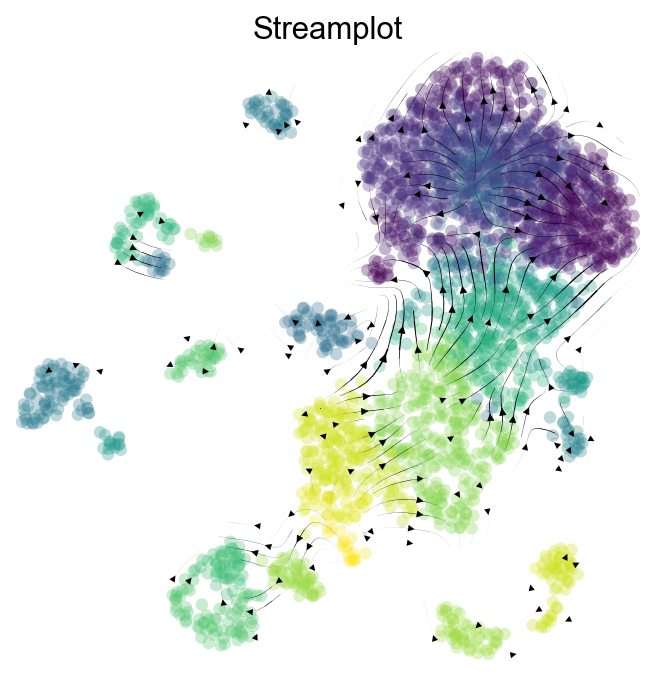

In [16]:
#Colored by pseudotime

fig, ax = VIA.core.via_streamplot_ov(adata,'clusters',
                             v0,density_grid=0.8, scatter_size=30, color_scheme='time', linewidth=0.5, 
                             min_mass = 1, cutoff_perc = 5, scatter_alpha=0.3, marker_edgewidth=0.1, 
                             density_stream = 2, smooth_transition=1, smooth_grid=0.5,dpi=80,)
fig.set_size_inches(5,5)

## Probabilistic pathways and Memory

Visualize the probabilistic pathways from root to terminal state as indicated by the lineage likelihood. The higher the linage likelihood, the greater the potential of that particular cell to differentiate towards the terminal state of interest. Changing the memory paramater will alter the specificity of the lineage pathway. This can be visualized at the single-cell level but also combined with the Atlas View which visualizes cell-cell connectivity and pathways

Key Parameters:
- marker_lineages (list) of terminal clusters

2025-08-04 21:00:17.073822	Marker_lineages: [34, 4, 5, 36, 7, 8, 38, 11, 39, 16, 19, 25, 26, 30, 31]
2025-08-04 21:00:17.075716	The number of components in the original full graph is 1
2025-08-04 21:00:17.075753	For downstream visualization purposes we are also constructing a low knn-graph 
2025-08-04 21:00:23.283585	Check sc pb 0.9999999999999999 
f getting majority comp
2025-08-04 21:00:23.307139	Cluster path on clustergraph starting from Root Cluster 33 to Terminal Cluster 34: [33, 23, 2, 1, 3, 24, 18, 37, 6, 34]
2025-08-04 21:00:23.307185	Cluster path on clustergraph starting from Root Cluster 33 to Terminal Cluster 4: [33, 23, 2, 1, 3, 24, 18, 22, 4]
2025-08-04 21:00:23.307216	Cluster path on clustergraph starting from Root Cluster 33 to Terminal Cluster 5: [33, 23, 2, 1, 3, 24, 18, 37, 6, 5]
2025-08-04 21:00:23.307251	Cluster path on clustergraph starting from Root Cluster 33 to Terminal Cluster 36: [33, 23, 21, 40, 36]
2025-08-04 21:00:23.307278	Cluster path on clustergraph star

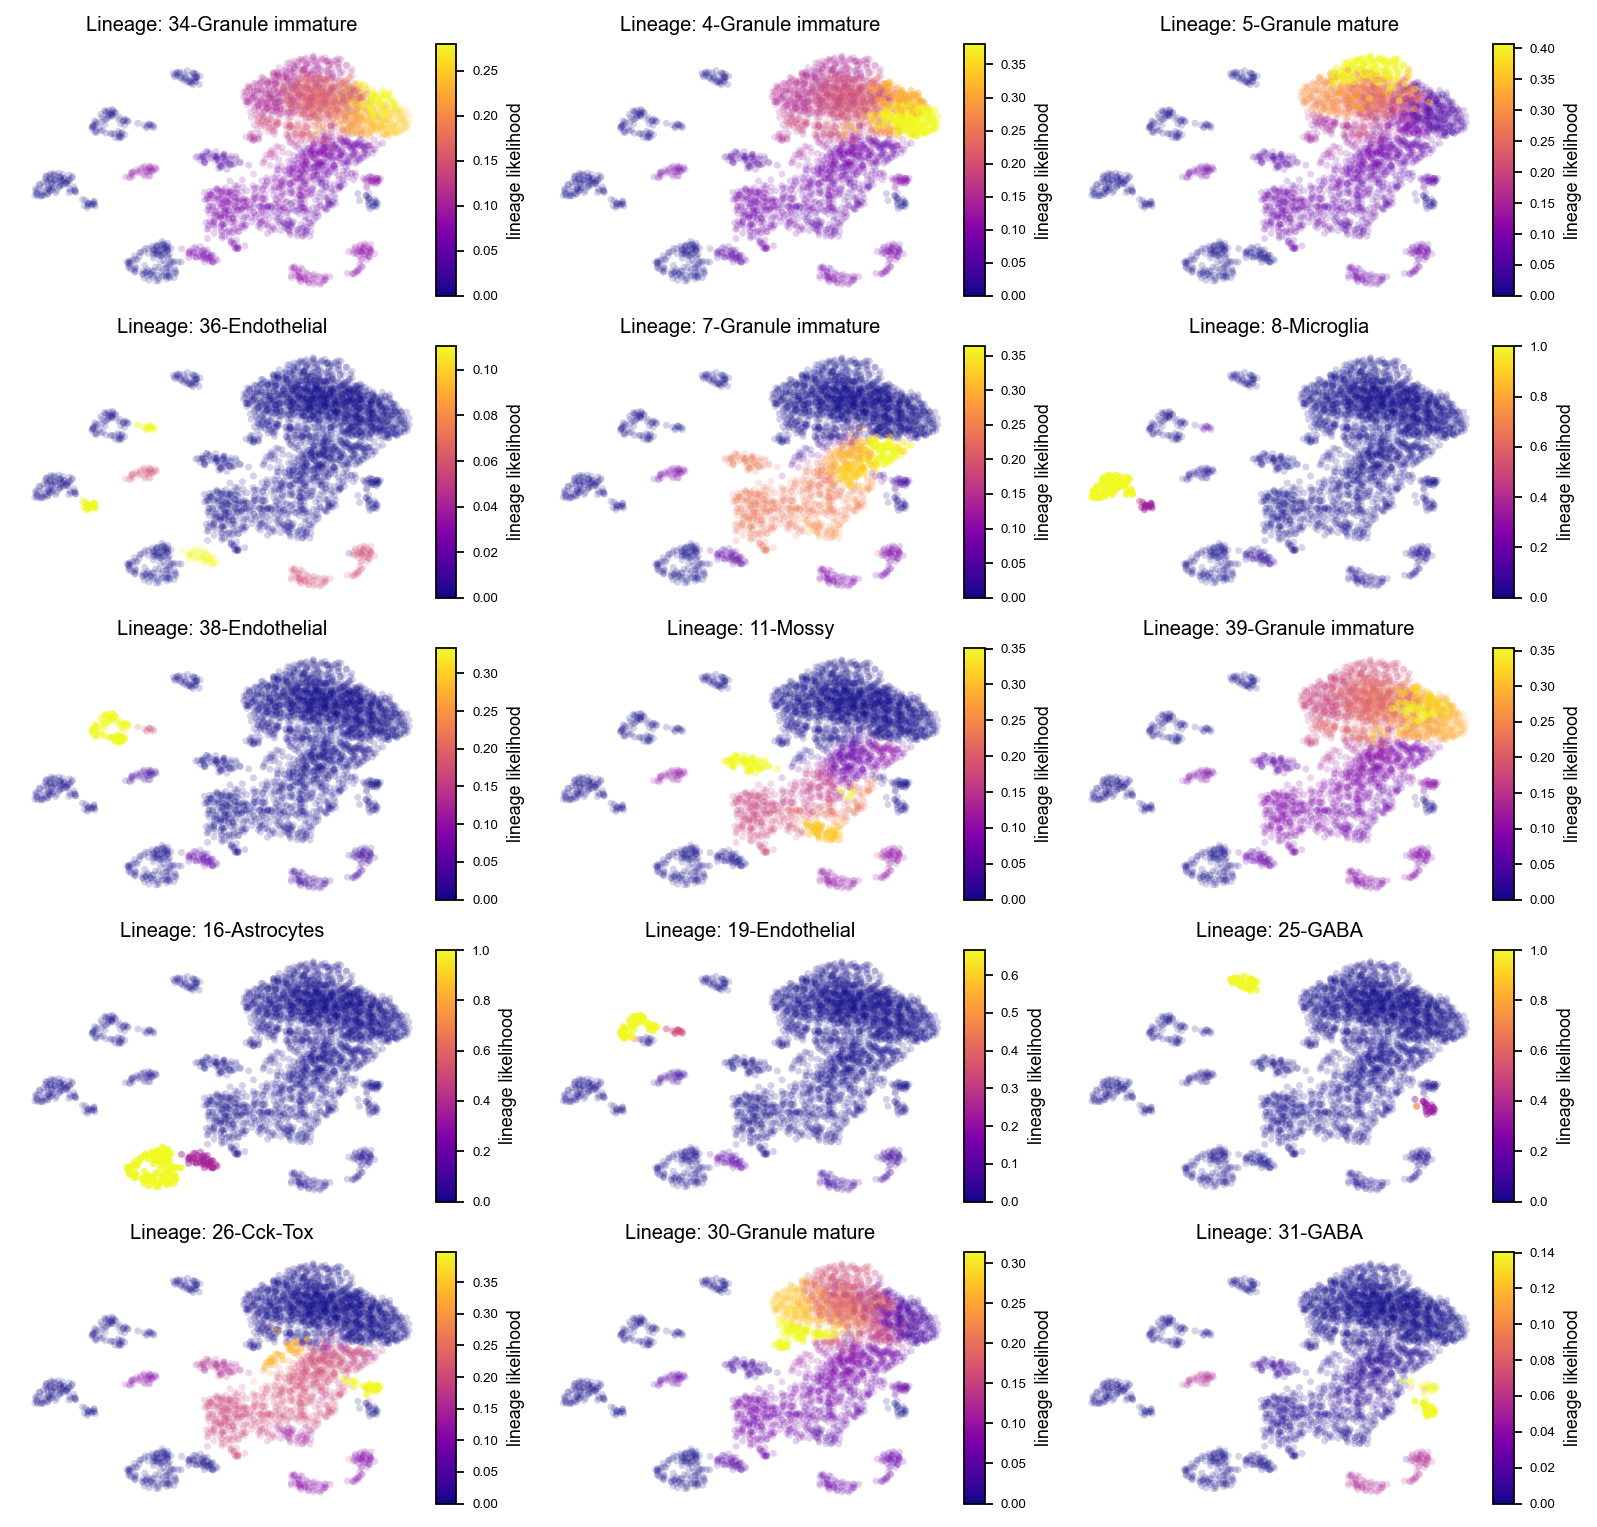

In [17]:
fig, axs= VIA.core.plot_sc_lineage_probability(via_object=v0, dpi=80,
                                          #marker_lineages=[7,11,12,15,20,22], 
                                          embedding=adata.obsm['X_umap']) #marker_lineages=v0.terminal_clusters to plot all
fig.set_size_inches(12,12)

location of 5 is at [2] and 2
setting vmin to 0.0
location of 25 is at [11] and 11
setting vmin to 0.0
location of 4 is at [1] and 1
setting vmin to 0.0


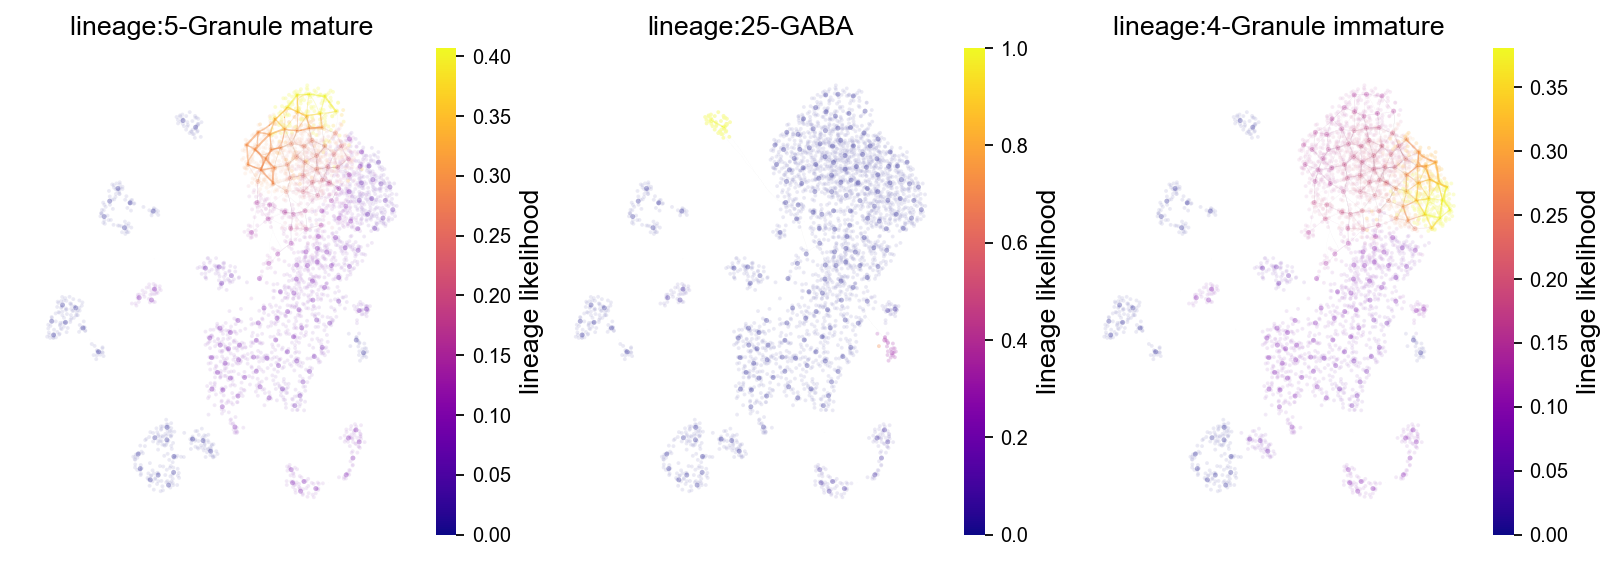

In [18]:
fig, axs= VIA.core.plot_atlas_view(via_object=v0, dpi=80,
                              lineage_pathway=[5,25,4],
                                   fontsize_title = 12,
                                 fontsize_labels = 12,
                             ) #marker_lineages=v0.terminal_clusters to plot all
fig.set_size_inches(12,4)

## Visualise gene/feature graph

View the gene expression along the VIA graph. We use the computed HNSW small world graph in VIA to accelerate the gene imputation calculations (using similar approach to MAGIC) as follows:

In [19]:
import pandas as pd
gene_list_magic =['Tmsb10', 'Hn1', ]
df = adata.to_df()
df_magic = v0.do_impute(df, magic_steps=3, gene_list=gene_list_magic) #optional

shape of transition matrix raised to power 3 (2930, 2930)


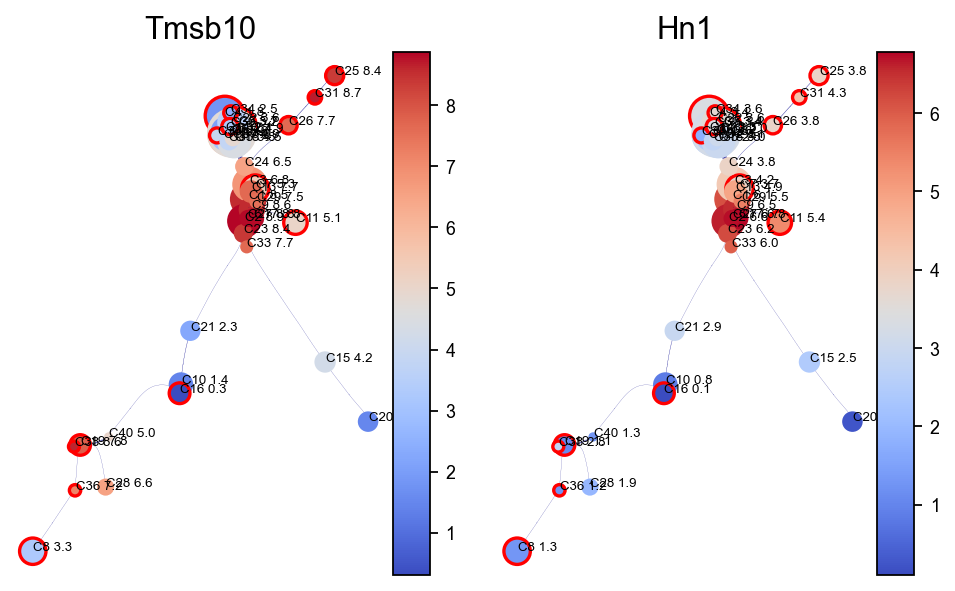

In [20]:
fig, axs = VIA.core.plot_viagraph(via_object=v0, 
                                  type_data='gene',
                                  df_genes=df_magic, 
                                  gene_list=gene_list_magic[0:3], arrow_head=0.1)
fig.set_size_inches(12,4)

## Gene Dynamics

The gene dynamics along pseudotime for all detected lineages are automatically inferred by VIA. These can be interpreted as the change in gene expression along any given lineage.

Key Parameters
- n_splines
- spline_order
- gene_exp (dataframe) single-cell level gene expression of select genes (gene imputation is an optional pre-step)

Area under curve Tmsb10 for branch Granule immature is 6.104141736190897
Area under curve Tmsb10 for branch Granule immature is 6.120889201002902
Area under curve Tmsb10 for branch Granule mature is 6.260081514829693
Area under curve Tmsb10 for branch Endothelial is 2.0008197528727867
Area under curve Tmsb10 for branch Granule immature is 5.148829751707588
Area under curve Tmsb10 for branch Microglia is 2.624292123681254
Area under curve Tmsb10 for branch Endothelial is 3.884724570644028
Area under curve Tmsb10 for branch Mossy is 4.604828016456887
Area under curve Tmsb10 for branch Granule immature is 6.091445935035632
Area under curve Tmsb10 for branch Astrocytes is 0.801604873564623
Area under curve Tmsb10 for branch Endothelial is 1.2057144588703093
Area under curve Tmsb10 for branch GABA is 4.879484050107624
Area under curve Tmsb10 for branch Cck-Tox is 4.536733011918275
Area under curve Tmsb10 for branch Granule mature is 6.261189084613359
Area under curve Tmsb10 for branch GABA 

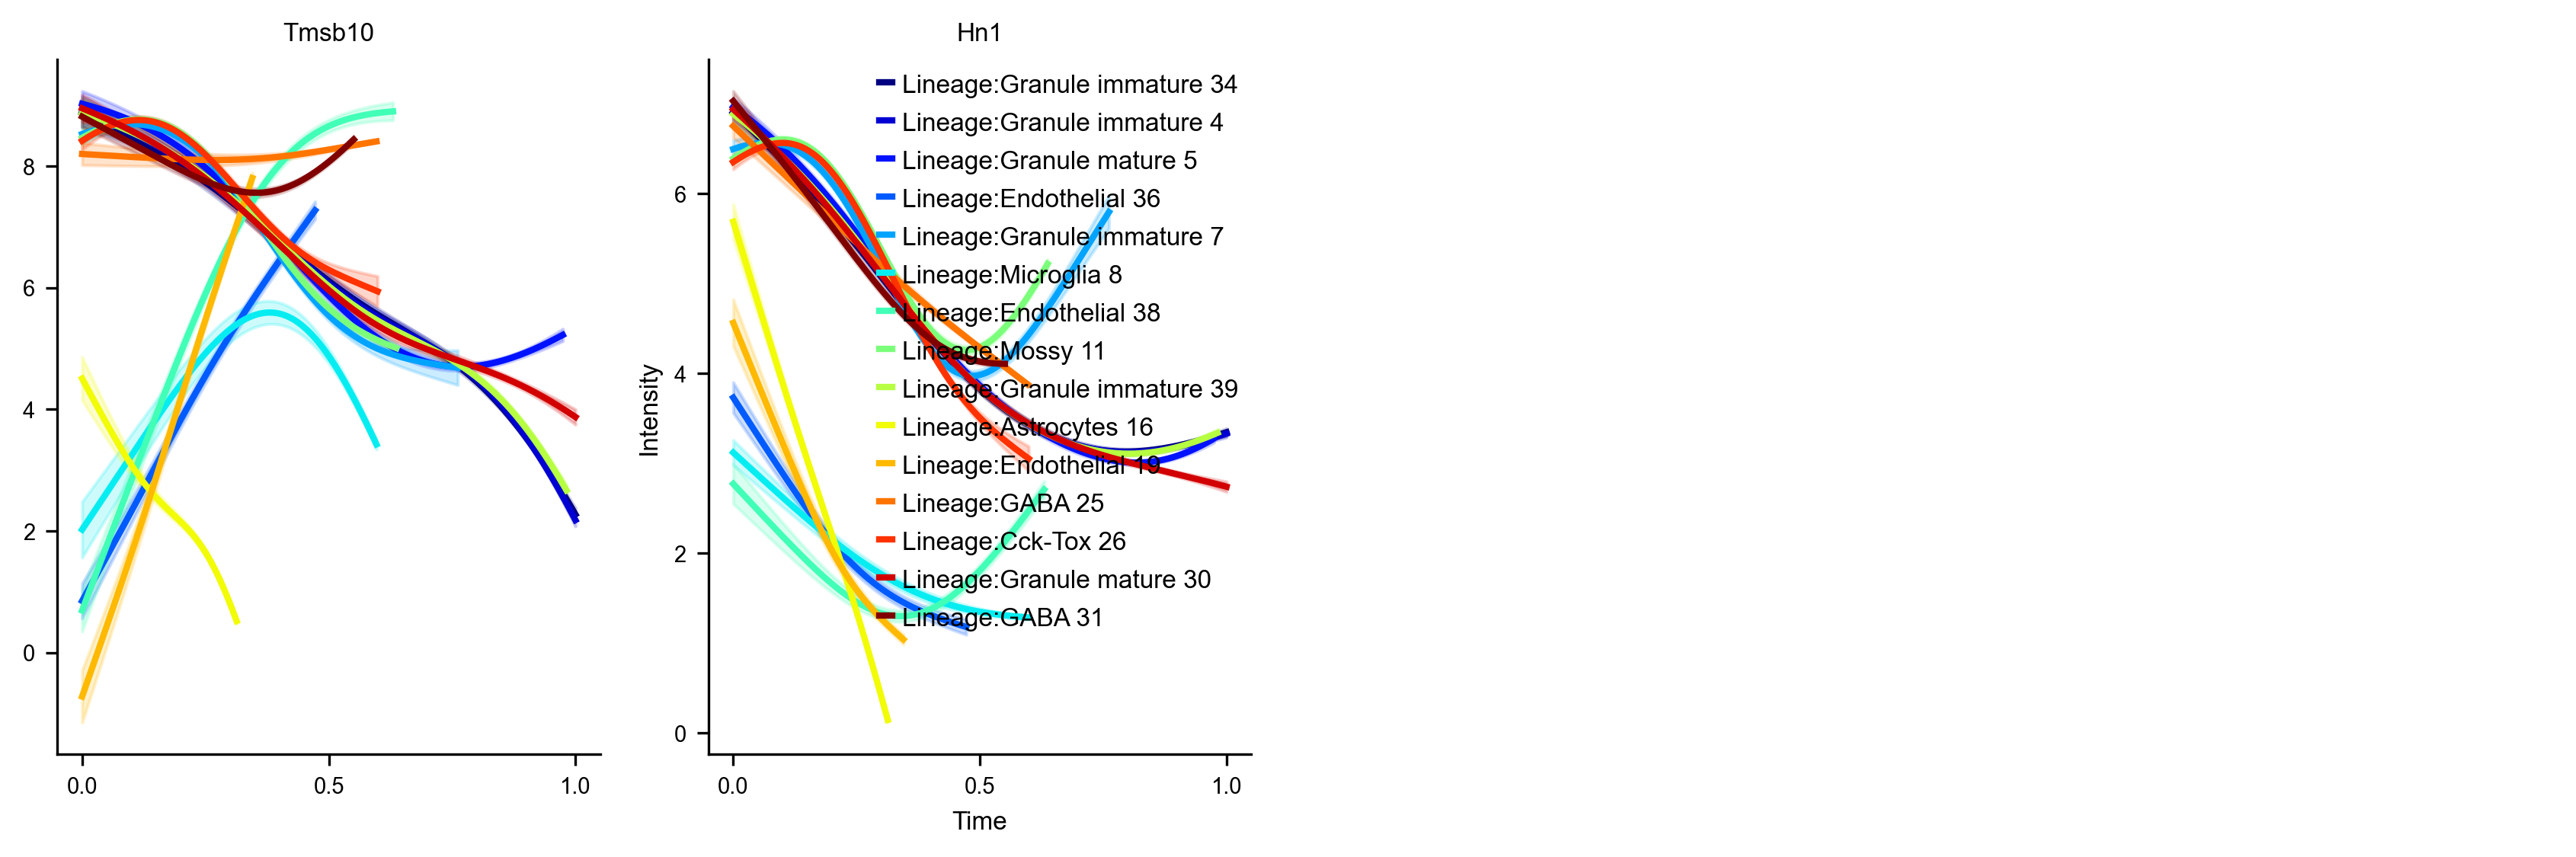

In [21]:
fig, axs=VIA.core.get_gene_expression(via_object=v0, #cmap_dict=color_dict,
                                      gene_exp=df_magic[gene_list_magic])
fig.set_size_inches(14,4)

branches [34, 5]


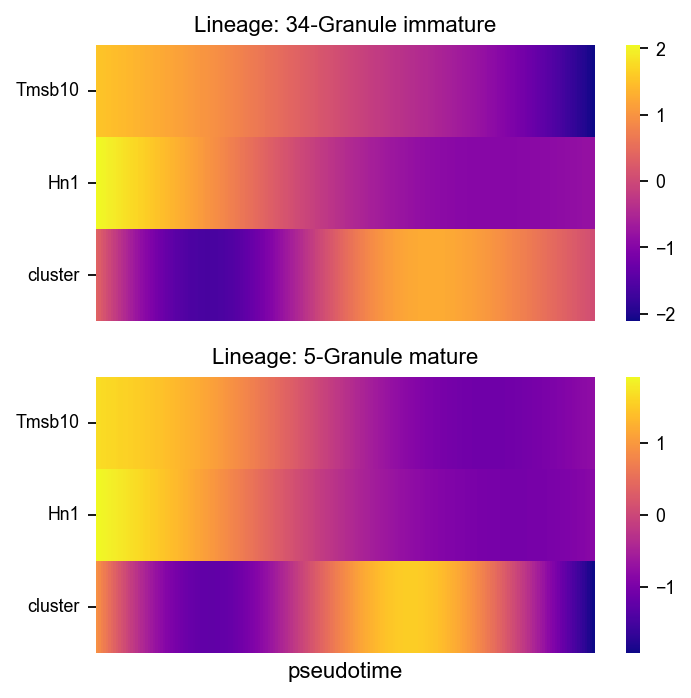

In [22]:
fig, axs = VIA.core.plot_gene_trend_heatmaps(via_object=v0, 
                                             df_gene_exp=df_magic, cmap='plasma',
                                         marker_lineages=[34,5])
fig.set_size_inches(5,5)

In [ ]:
VIA.core.animate_streamplot_ov(adata,'clusters',v0, embedding=adata.obsm['X_umap'],
                       cmap_stream='Blues', 
                       scatter_size=200, scatter_alpha=0.2, marker_edgewidth=0.15, 
                        density_grid=0.7, linewidth=0.1, 
                       segment_length=1.5, 
                       saveto='result/animation_test.gif')

In [ ]:
from IPython.display import Image

with open('result/animation_test.gif','rb') as file:
    display(Image(file.read(),width=400,height=400))

In [ ]:
VIA.core.animate_atlas(via_object=v0, 
                        extra_title_text='test animation',
                        n_milestones=None,
                        saveto='result/edgebundle_test.gif')

In [ ]:
from IPython.display import Image

with open('result/edgebundle_test.gif','rb') as file:
    display(Image(file.read(),width=500,height=500))